In [1]:
import os
import json
import yaml

from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, List, Dict, Tuple

from langchain_openai import ChatOpenAI
from langchain_core.runnables import chain
from langchain_core.prompts import load_prompt
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
with open('../data/document/역도/documentParseGraph_state.json', 'r') as f:
    state = json.load(f)

class GraphState(TypedDict):
    filepath: Annotated[str, 'filepath']
    filepath_pdf: Annotated[str, 'pdf filepath']
    originData: Annotated[List[Dict], 'originData']
    documents: Annotated[List[Dict], 'documents']
    heading_structure: Annotated[List[str], 'heading structure. last heading is borderline']
    unused_elements: Annotated[List[Tuple[str, str]], 'unused elements']
    image_result: Annotated[List[Dict], 'result of image information extractor ']
    chart_result: Annotated[List[Dict], 'result of chart information extractor ']
    table_result: Annotated[List[Dict], 'result of table information extractor ']
    
    normal_table: Annotated[List[Dict], 'table where class is not a cutoff']
    cutoff_table: Annotated[List[Dict], 'table where class is a cutoff']
state = GraphState(**state)

In [3]:
state

{'filepath': '../data/document/역도/역도 훈련프로그램 구성 및 지도안_edited.json',
 'filepath_pdf': '../data/document/역도/역도 훈련프로그램 구성 및 지도안.pdf',
 'originData': [{'category': 'heading1',
   'coordinates': [{'x': 0.2295, 'y': 0.0994},
    {'x': 0.7689, 'y': 0.0994},
    {'x': 0.7689, 'y': 0.128},
    {'x': 0.2295, 'y': 0.128}],
   'id': 0,
   'page': 1,
   'relatedID': [],
   'class': 'heading1',
   'text': 'Ⅴ.역도 훈련프로그램 구성 및 지도안'},
  {'category': 'heading1',
   'coordinates': [{'x': 0.1225, 'y': 0.2216},
    {'x': 0.4524, 'y': 0.2216},
    {'x': 0.4524, 'y': 0.2453},
    {'x': 0.1225, 'y': 0.2453}],
   'id': 1,
   'page': 1,
   'relatedID': [],
   'class': 'heading2',
   'text': '1. 훈련프로그램의 구성 원리'},
  {'category': 'paragraph',
   'coordinates': [{'x': 0.123, 'y': 0.2572},
    {'x': 0.8773, 'y': 0.2572},
    {'x': 0.8773, 'y': 0.3385},
    {'x': 0.123, 'y': 0.3385}],
   'id': 2,
   'page': 1,
   'relatedID': [],
   'class': 'default',
   'text': '역도 훈련프로그램의 구성은 트레이닝의 원리에 입각하여 안전하고 효과적인 훈\n련 프로그램을 설계하여 선

# Document Summary Node

In [4]:
def summary_chain(data_batches) -> List[str]:
    '''
    document에 text가 없을 수 있지만 heading이 있어, 요약이 무조건 됨
    '''
    llm = ChatOpenAI(
        temperature=0,
        model_name="gpt-4o-mini"
    )

    stuff_prompt = load_prompt('../prompt/summary/stuff_20250317_02.yaml')
    stuff_chain = stuff_prompt | llm | StrOutputParser()

    stuff_result = stuff_chain.batch(data_batches, config={"max_concurrency": 10})

    return stuff_result

In [5]:
def documentSummaryNode(state: GraphState) -> Dict:
    '''
    '''
    stuff_dataset = []
    for document in state['documents']:
        heading = []
        for heading_key in state['heading_structure']:
            sentence = document['meta']['heading'][heading_key]
            if sentence != None:
                heading.append(sentence.replace('\n', ''))
        heading = "\n".join(heading)

        text = []
        for element in document['content']:
            if element['category'] == 'paragraph':
                text.append(' '.join([sentence.replace('\n', '') for sentence in element['text']]))

        text = " ".join(text)
        stuff_dataset.append({'document': heading + "\n" + text})

    
    summary_result = summary_chain(stuff_dataset)
    result = {'documents': []}
    for i, document in enumerate(state['documents']):
        copy_document = document.copy()
        copy_document['meta']['summary'] = summary_result[i]
        result['documents'].append(copy_document)

    return result

# Crop Node

In [6]:
import pymupdf

def crop_image(img, coordinates, output_path):
    """
    이미지를 주어진 좌표에 따라 자르고 저장하는 정적 메서드

    :param img: 원본 이미지 객체
    :param coordinates: 정규화된 좌표 (x1, y1, x2, y2)
    :param output_path: 저장할 파일 경로
    """
    img_width, img_height = img.size
    
    x1, y1, x2, y2 = [
        int(coord * dim)
        for coord, dim in zip(coordinates, [img_width, img_height] * 2)
    ]
    cropped_img = img.crop((x1, y1, x2, y2))
    cropped_img.save(output_path)


def pdf_to_image(pdf_file, page_num, dpi=300):
    """
    PDF 파일의 특정 페이지를 이미지로 변환하는 메서드

    :param page_num: 변환할 페이지 번호 (1부터 시작)
    :param dpi: 이미지 해상도 (기본값: 300)
    :return: 변환된 이미지 객체
    """

    from PIL import Image

    with pymupdf.open(pdf_file) as doc:
        page = doc[page_num].get_pixmap(dpi=dpi)
        target_page_size = [page.width, page.height]
        page_img = Image.frombytes("RGB", target_page_size, page.samples)
    return page_img
    
def crop_make_dir(pdf_path):
    path_split = pdf_path.split('/')
    name = path_split[-1].split('.')[0]

    path_base = '/'.join(path_split[0:-1] + [name])
    if not os.path.isdir(path_base):
        os.mkdir(path_base)

    folder_path_dict = {'figure': '',
                        'table': '',
                        'chart': ''}

    for folder in ['figure', 'table', 'chart']:
        folder_path = os.path.join(path_base, folder)
        
        if not os.path.isdir(folder_path):
            os.mkdir(folder_path)

        folder_path_dict[folder] = folder_path
    return folder_path_dict

In [7]:
def cropNode(state: GraphState) -> Dict:
    '''
    category가 ['figure', 'chart', 'table']에 해당하는 element를 저장하고 path를 기록하는 과정
    '''
    folder_path_dict = crop_make_dir(state['filepath_pdf'])
    new_document = state['documents'].copy()

    for i, element in enumerate(state['documents']):
        for j, ele in enumerate(element['content']):
            if ele['category'] in ['figure', 'chart', 'table']:
                page_index = ele.get('page') - 1
                coordinates = ele['coordinates']
                coordinates = (coordinates[0]['x'], coordinates[0]['y'], coordinates[2]['x'], coordinates[2]['y'])

                page_img = pdf_to_image(state['filepath_pdf'], page_index)
                
                file_name = ele.get('caption', f"{ele['id']}")
                output_path = os.path.join(folder_path_dict[ele['category']], file_name + '.jpg')
                crop_image(page_img, coordinates, output_path)

                new_document[i]['content'][j]['file_path'] = output_path
    
    return {'documents': new_document}

# Infomation Extractor

In [8]:
def load_chat_prompt(yaml_file):
    with open(yaml_file, "r", encoding="utf-8") as file:
        return yaml.safe_load(file)

In [9]:
import io
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        image_content = image_file.read()
        file_ext = os.path.splitext(image_path)[1].lower()

        if file_ext in ['.jpg', '.jpeg']:
            mime_type = 'image/jpeg'
        elif file_ext == '.png':
            mime_type = 'image/png'
        else:
            mime_type = 'image/unknown'

        return base64.b64encode(image_content).decode("utf-8"), mime_type


def encode_pil_image(image, format: str = 'PNG') -> (str, str):
    buffered = io.BytesIO()
    image.save(buffered, format=format)
    image_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
    mime_type = f"image/{format.lower()}"
    return image_base64, mime_type




## Image Information Extractor

In [10]:
def imageExtractorNode(state: GraphState) -> Dict:
    '''
    1. state['documents']에서 category가 Image인 element를 포함하는 document를 추출
        - 이 때, 해당 document id와 element id를 기록
    2. llm_batch에 적합하게 데이터셋 생성
    3. 뽑힌 document의 Image element를 대상으로 batch를 사용하여 정보를 추출
    4. document id, element id, 추출 정보를 state['image_result']에 맞게 저장 및 반환
    '''

    id_list = [] # set(docuemnt id, element id)
    base64_list = []
    imageType_list = []
    title_list = []
    context_list = []

    class ImageInformationExtract(BaseModel):
        detail: str = Field(description='key insights and information visible in the IMAGE')
        hypotheticalQuestions: List[str] = Field(description="relevant hypothetical questions")
    
    parser = PydanticOutputParser(pydantic_object=ImageInformationExtract)
    prompt = load_chat_prompt('../prompt/information_image/image_20250304_01.yaml')
    chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
    chat_prompt = chat_prompt.partial(format=parser.get_format_instructions(), language='KOREAN')
    
    
    for document in state['documents']:
        document_id = document['meta']['index']
        document_summary = document['meta'].get('summary', '')
        for element in document['content']:
            if element['category'] == 'figure':
                element_id = element['id']
                base64, image_type = encode_image(element['file_path'])
                
                id_list.append((document_id, element_id))
                base64_list.append(base64)
                imageType_list.append(image_type)
                context_list.append(document_summary)
                title_list.append(element.get('caption', ''))

    # 추출할 이미지가 없는 경우 빈 결과 반환
    if not id_list:
        return {"image_result": []}

    image_dataset = [{'base64_image': base64, 'image_type': imageType, 'context': context, 'title': title} 
                    for base64, imageType, context, title in zip(base64_list, imageType_list, context_list, title_list)]

    llm = ChatOpenAI(model='gpt-4o', temperature=0)
    image_chain = chat_prompt | llm
    results = image_chain.batch(image_dataset, config={"max_concurrency": 10})

    # 결과 처리
    image_result = []
    
    for idx, result in enumerate(results):
        document_id, element_id = id_list[idx]
        
        try:
            parsed_result = parser.parse(result.content)
            
            image_info = {
                "document_id": document_id,
                "element_id": element_id,
                "information": {
                    "detail": parsed_result.detail,
                    "hypotheticalQuestions": parsed_result.hypotheticalQuestions
                }
            }
        except Exception as e:
            # 파싱 실패 시 원본 결과 저장
            image_info = {
                "document_id": document_id,
                "element_id": element_id,
                "information": {
                    "raw_result": result.content,
                    "parse_error": str(e)
                }
            }
        
        image_result.append(image_info)
    
    return {"image_result": image_result}

# Chart Information Extractor

In [11]:
def chartExtractorNode(state: GraphState) -> Dict:
    '''
    1. state['documents']에서 category가 chart인 element를 포함하는 document를 추출
        - 이 때, 해당 document id와 element id를 기록
    2. llm_batch에 적합하게 데이터셋 생성
    3. 뽑힌 document의 Chart element를 대상으로 batch를 사용하여 정보를 추출
    4. document id, element id, 추출 정보를 state['image_result']에 맞게 저장 및 반환
    '''

    id_list = [] # set(docuemnt id, element id)
    base64_list = []
    imageType_list = []
    title_list = []
    context_list = []

    class ChartInfomationExtract(BaseModel):
        detail: str = Field(description='key insights and information visible in the Chart')
        hypotheticalQuestions: List[str] = Field(description="relevant hypothetical questions")    
    
    parser = PydanticOutputParser(pydantic_object=ChartInfomationExtract)
    prompt = load_chat_prompt('../prompt/information_chart/chart_20250304_01.yaml')
    chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
    chat_prompt = chat_prompt.partial(format=parser.get_format_instructions(), language='KOREAN')
    
    for document in state['documents']:
        document_id = document['meta']['index']
        document_summary = document['meta'].get('summary', '')
        for element in document['content']:
            if element['category'] == 'chart':
                element_id = element['id']
                base64, image_type = encode_image(element['file_path'])
                
                id_list.append((document_id, element_id))
                base64_list.append(base64)
                imageType_list.append(image_type)
                context_list.append(document_summary)
                title_list.append(element.get('caption', ''))

    # 추출할 이미지가 없는 경우 빈 결과 반환
    if not id_list:
        return {"chart_result": []}

    image_dataset = [{'base64_image': base64, 'image_type': imageType, 'context': context, 'title': title} 
                    for base64, imageType, context, title in zip(base64_list, imageType_list, context_list, title_list)]

    llm = ChatOpenAI(model='gpt-4o', temperature=0)
    image_chain = chat_prompt | llm
    results = image_chain.batch(image_dataset, config={"max_concurrency": 10})

    # 결과 처리
    chart_result = []
    
    for idx, result in enumerate(results):
        document_id, element_id = id_list[idx]
        
        try:
            parsed_result = parser.parse(result.content)
            
            image_info = {
                "document_id": document_id,
                "element_id": element_id,
                "information": {
                    "detail": parsed_result.detail,
                    "hypotheticalQuestions": parsed_result.hypotheticalQuestions
                }
            }
        except Exception as e:
            image_info = {
                "document_id": document_id,
                "element_id": element_id,
                "information": {
                    "raw_result": result.content,
                    "parse_error": str(e)
                }
            }
        
        chart_result.append(image_info)
    
    return {"chart_result": chart_result}

# Table Information Extractor

In [12]:
import PIL

def merge_images(image_paths):    
    images = [PIL.Image.open(img_path) for img_path in image_paths]
    width = min(img.width for img in images)
    images = [img.resize((width, img.height)) for img in images]
    merged = PIL.Image.new('RGB', (width, sum(img.height for img in images)))
    y_offset = 0
    for img in images:
        merged.paste(img, (0, y_offset))
        y_offset += img.height
    
    return merged

In [13]:
def classifyTableNode(state: GraphState) -> Dict:
    '''
    중요한 점은, cutoff는 앞에 테이블이 있어야 하고, 연속적으로 나올 수 있음.
    이 과정에서 전처리까지 다 해버리자. cutoff는 이미지를 하나로 병합하고 진행하는 것이 좋은 방법이었으니,
    이미지도 병합해버리자.
    이미지 병합하는 것은 함수로 만들면 될거 같고,

    cutoff_list와 normal_list에서 나와야하는 결과값은 {base64_image, image_type, context, title} 이게 필요함.
    할 수 있다!!!
    '''
    cutoff_list = [] 
    normal_list = [] 

    for document in state['documents']:
        document_id = document['meta']['index']
        document_summary = document['meta'].get('summary', '')

        element_sequence = []
        element_ids = []
        element_paths = []
        
        for element in document['content']:
            element_type = 'c' if element['class'] == 'cutOff' else 't' if element['category'] == 'table' else 'e'
            element_sequence.append(element_type)
            element_ids.append(element.get('id', ''))
            element_paths.append(element.get('file_path', ''))

        current_type = []
        first_index = 0
        last_index = 0
        
        for i, element_type in enumerate(element_sequence):
            if current_type == []:
                if element_type == 't':
                    current_type.append('t')
                    first_index = i
                    last_index = i
            else: # current_type이 ['t'] 또는 ['t', 'c'] 이런 경우
                if element_type == 'c':
                    current_type.append('c')
                    last_index = i
                
                else: # element_type 이 't' 또는 'e'인 경우
                    if len(current_type) > 1:
                        merge_image = merge_images(element_paths[first_index : last_index + 1])
                        base64_image, image_type = encode_pil_image(merge_image)

                        cutoff_list.append({'dataset': {'base64_image': base64_image, 
                                                        'image_type': image_type, 
                                                        'context': document_summary, 
                                                        'title': document['content'][first_index].get('caption', '')},
                                            'ids': [(document_id, document['content'][index].get('id')) for index in range(first_index, last_index + 1)]})

                    elif len(current_type) == 1:
                        base64_image, image_type = encode_image(element_paths[first_index])
                        normal_list.append({'dataset': {'base64_image': base64_image, 
                                                        'image_type': image_type, 
                                                        'context': document_summary, 
                                                        'title': document['content'][first_index].get('caption', '')},
                                            'ids': [(document_id, document['content'][first_index].get('id'))]})

                    if element_type == 't':
                        current_type = ['t']
                        first_index = i
                        last_index = i
                    else:
                        current_type = []
                        first_index = i
                        last_index = i
        
        # 마지막에 남아있는 element에 대한 작업 필요
        if current_type:
            if len(current_type) > 1:
                merge_image = merge_images(element_paths[first_index : last_index + 1])                           
                base64_image, image_type = encode_pil_image(merge_image)

                cutoff_list.append({'dataset': {'base64_image': base64_image, 
                                                'image_type': image_type, 
                                                'context': document_summary, 
                                                'title': document['content'][first_index].get('caption', '')},
                                    'ids': [(document_id, document['content'][index].get('id')) for index in range(first_index, last_index + 1)]})
            else: 
                base64_image, image_type = encode_image(element_paths[first_index])
                normal_list.append({'dataset': {'base64_image': base64_image, 
                                                'image_type': image_type, 
                                                'context': document_summary, 
                                                'title': document['content'][first_index].get('caption', '')},
                                    'ids': [(document_id, document['content'][first_index].get('id'))]})
    return {
        'normal_table': normal_list,
        'cutoff_table': cutoff_list
    }


### Normal Table

In [14]:
def tableNormalConvertingNode(state: GraphState) -> Dict:
    prompt = load_chat_prompt('../prompt/information_table/table_raw_20250312_01.yaml')
    chat_prompt = ChatPromptTemplate.from_messages(prompt["messages"])
    
    llm = ChatOpenAI(model='gpt-4o', temperature=0)
    normal_extract_chain = chat_prompt | llm

    normal_dataset = []
    for data in state['normal_table']:
        dt = data['dataset']
        normal_dataset.append({'base64_image' : dt['base64_image'], 'image_type': dt['image_type']})
    
    results = normal_extract_chain.batch(normal_dataset, config={'max_concurrency': 2})

    for i, result in enumerate(results):
        state['normal_table'][i]['dataset']['table_json'] = result.content

    return {'normal_table': state['normal_table']}

### Cutoff Table

In [15]:
def tableCutoffConvertingNode(state: GraphState) -> Dict:
    prompt = load_chat_prompt('../prompt/information_table/table_cutoff_preprocessed_20250304_01.yaml')
    chat_prompt = ChatPromptTemplate.from_messages(prompt["messages"])
    chat_prompt = chat_prompt.partial(language='KOREAN')
    
    llm = ChatOpenAI(model='gpt-4o', temperature=0)
    cutoff_extract_chain = chat_prompt | llm

    cutoff_dataset = []
    for data in state['cutoff_table']:
        dt = data['dataset']
        cutoff_dataset.append({'base64_image' : dt['base64_image'], 'image_type': dt['image_type']})
    
    results = cutoff_extract_chain.batch(cutoff_dataset, config={'max_concurrency': 2})

    for i, result in enumerate(results):
        state['cutoff_table'][i]['dataset']['table_json'] = result.content

    return {'cutoff_table': state['cutoff_table']}

### Table Inforamtion

In [16]:
def tableInformationNode(state: GraphState) -> Dict:
    class TableInformationExtract(BaseModel):
        detail: str = Field(description='key insights and information visible in the Chart')
        hypotheticalQuestions: List[str] = Field(description="relevant hypothetical questions")   
    
    parser = PydanticOutputParser(pydantic_object=TableInformationExtract)
        
    prompt = load_chat_prompt('../prompt/information_table/table_info_20250319_01.yaml')
    chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
    chat_prompt = chat_prompt.partial(format=parser.get_format_instructions(), language='KOREAN')

    llm = ChatOpenAI(model='gpt-4o', temperature=0)
    information_extract_chain = chat_prompt | llm

    cutoff_dataset = []
    normal_dataset = []
    for data in state['cutoff_table']:  
        dt = data['dataset']
        cutoff_dataset.append({'table_json': dt['table_json'], 'title': dt['title'], 'context': dt['context']})
        
    for data in state['normal_table']:
        dt = data['dataset']
        normal_dataset.append({'table_json': dt['table_json'], 'title': dt['title'], 'context': dt['context']})

    cutoff_results = information_extract_chain.batch(cutoff_dataset, config={'max_concurrency': 2})
    normal_results = information_extract_chain.batch(normal_dataset, config={'max_concurrency': 2})

    results = []

    for i, normal_result in enumerate(normal_results):
        document_id = state['normal_table'][i]['ids'][0][0]
        element_id = state['normal_table'][i]['ids'][0][1]
        normal_table = state['normal_table'][i]['dataset']['table_json']
        
        try:
            normal_content = parser.parse(normal_result.content)
            normal_info = {
                'document_id': document_id,
                'element_id':element_id,
                'information': {
                    'table_json': normal_table,
                    'detail': normal_content.detail,
                    'hypotheticalQuestions': normal_content.hypotheticalQuestions,
                }
            }
        except Exception as e:
            normal_info = {
                "document_id": document_id,
                "element_id": element_id,
                "information": {
                    'table_json': normal_table,
                    "raw_result": normal_content.content,
                }
            }
        results.append(normal_info)


    for i, cutoff_result in enumerate(cutoff_results):
        document_id = state['cutoff_table'][i]['ids'][0][0]
        element_id = [ids[1] for ids in state['cutoff_table'][i]['ids']] # 아이디가 여러 개 => 리스트, 나중에 병합시 주의 필요
        cutoff_table = state['cutoff_table'][i]['dataset']['table_json']

        try:
            cutoff_content = parser.parse(cutoff_result.content)
            cutoff_info = {
                'document_id': document_id,
                'element_id': element_id,
                'information': {
                    'table_json': cutoff_table,
                    'detail': cutoff_content.detail,
                    'hypotheticalQuestions': cutoff_content.hypotheticalQuestions,
                }
            }
        except Exception as e:
            cutoff_info = {
                "document_id": document_id,
                "element_id": element_id,
                "information": {
                    'table_json': cutoff_table,
                    "raw_result": cutoff_content.content,
                }
            }

        results.append(cutoff_info)
        
    return {'table_result': results}

# align node
- 이 노드의 목표는 state['document']를 변경하는 것
- coordinates는 제거해야 함.
- relatedID 제거해야 함.
- 연속된 paragraph는 병합해야 함.
- meta에 페이지의 범위를 추가해야 함.
- class도 제거되어야 함.
- category가 chart이며, class가 cutoff인 element의 filepath는 []로 저장해야해.
    - 이것은 state['cutoff_table']에서 ['ids']를 확인하면 됨.

In [17]:
def alignNode(state: GraphState) -> Dict:
    """
    문서 데이터를 최종 형태로 정리하는 함수
    - 불필요한 필드 제거 (coordinates, relatedID, class 등)
    - 연속된 paragraph 병합
    - 각 요소의 정보를 타입별로 적절히 구성
    - 메타데이터에 페이지 목록(pages) 추가
    - 파싱 오류가 있는 경우 적절히 처리
    """
    state_json = json.dumps(state)
    with open(os.path.splitext(state['filepath_pdf'])[0] + '_before_align.json', 'w', encoding='utf-8') as f:
        f.write(state_json)

    result = []
    
    # 테이블 정보 매핑 구성
    table_info_map = {}
    processed_element_ids = set() # 이미 처리된 element_id 추적 세트
    if 'table_result' in state:
        for table_info in state['table_result']:
            doc_id = table_info['document_id']
            elem_id = table_info['element_id']
            
            # 단일 ID 또는 ID 리스트 모두 처리
            if isinstance(elem_id, list):
                for i, eid in enumerate(elem_id):
                    if i == 0:
                        table_info_map[(doc_id, eid)] = table_info['information']
                    else:
                        processed_element_ids.add((doc_id, eid))

            else:
                table_info_map[(doc_id, elem_id)] = table_info['information']
    
    # 이미지 정보 매핑 구성
    image_info_map = {}
    if 'image_result' in state:
        for image_info in state['image_result']:
            doc_id = image_info['document_id']
            elem_id = image_info['element_id']
            image_info_map[(doc_id, elem_id)] = image_info['information']
    
    # 차트 정보 매핑 구성
    chart_info_map = {}
    if 'chart_result' in state:
        for chart_info in state['chart_result']:
            doc_id = chart_info['document_id']
            elem_id = chart_info['element_id']
            chart_info_map[(doc_id, elem_id)] = chart_info['information']
    
    for document in state['documents']:
        doc_id = document['meta']['index']
        
        new_document = {
            'meta': document['meta'].copy(),
            'content': []
        }
        
        # 모든 페이지 수집
        all_pages = []
        for element in document['content']:
            if 'page' in element:
                if isinstance(element['page'], list):
                    all_pages.extend(element['page'])
                else:
                    all_pages.append(element['page'])
        
        # 중복 제거 및 정렬
        all_pages = sorted(list(set(all_pages)))
        new_document['meta']['pages'] = all_pages
        
        # 요소 그룹화 및 처리
        i = 0
        while i < len(document['content']):
            element = document['content'][i]
            category = element.get('category', '')
            element_id = element.get('id', '')
            
            if (doc_id, element_id) in processed_element_ids:
                i += 1
                continue
            
            # 1. 연속된 paragraph 처리
            if category == 'paragraph':
                # 병합할 paragraph 텍스트 수집
                merged_text = element.get('text', '')
                if isinstance(merged_text, list):
                    merged_text = ' '.join(merged_text)
                
                curr_idx = i
                next_idx = i + 1
                
                # 연속된 paragraph 찾기
                while next_idx < len(document['content']):
                    next_element = document['content'][next_idx]
                    if next_element.get('category') == 'paragraph':
                        next_text = next_element.get('text', '')
                        if isinstance(next_text, list):
                            next_text = ' '.join(next_text)
                        merged_text += ' ' + next_text
                        next_idx += 1
                    else:
                        break
                                
                paragraph_info = {
                    'category': 'paragraph',
                    'information': merged_text
                }
                
                new_document['content'].append(paragraph_info)
                
                # 처리한 paragraph 요소 건너뛰기
                i = next_idx
                continue
            
            # 2. 테이블 처리
            elif category == 'table':
                caption = element.get('caption', '')
                filepaths = [element.get('file_path', '')] if element.get('file_path') else []
                
                # 테이블 정보 가져오기
                table_info = table_info_map.get((doc_id, element_id), {})
                
                table_result = {
                    'category': 'table',
                    'caption': caption,
                    'filepaths': filepaths,
                    'information': table_info
                }
                
                new_document['content'].append(table_result)
            
            # 3. 차트 처리
            elif category == 'chart':
                caption = element.get('caption', '')
                filepaths = [element.get('file_path', '')] if element.get('file_path') else []
                
                # 차트 정보 가져오기
                chart_info = chart_info_map.get((doc_id, element_id), {})
                
                # 파싱 오류 처리
                if 'raw_result' in chart_info:
                    information = image_info.get('raw_result', {}) 
                else:
                    # 정상 파싱된 데이터 사용
                    detail = chart_info.get('detail', '')
                    hypotheticalQuestions = chart_info.get('hypotheticalQuestions', [])
                    information = {'detail': detail, 'hypotheticalQuestions': hypotheticalQuestions}
                
                chart_result = {
                    'category': 'chart',
                    'caption': caption,
                    'filepaths': filepaths,
                    'information': information
                }
                
                new_document['content'].append(chart_result)
            
            # 4. 이미지(figure) 처리
            elif category == 'figure':
                caption = element.get('caption', '')
                filepaths = [element.get('file_path', '')] if element.get('file_path') else []
                
                # 이미지 정보 가져오기
                image_info = image_info_map.get((doc_id, element_id), {})
                
                # 파싱 오류 처리
                if 'raw_result' in image_info:
                    # 파싱 오류가 있는 경우 기본값 사용                
                    information = image_info.get('raw_result', {}) 
                else:
                    # 정상 파싱된 데이터 사용
                    detail = image_info.get('detail', '')
                    hypotheticalQuestions = image_info.get('hypotheticalQuestions', [])
                    information = {'hypotheticalQuestions': hypotheticalQuestions, 'detail': detail}
                
                figure_result = {
                    'category': 'figure',
                    'caption': caption,
                    'filepaths': filepaths,
                    'information': information
                }
                
                new_document['content'].append(figure_result)
            
            i += 1
        
        result.append(new_document)
    
    state['documents'] = result
    state_json = json.dumps(state)

    with open(os.path.splitext(state['filepath_pdf'])[0] + '_dataset.json', 'w', encoding='utf-8') as f:
        f.write(state_json)
    
    return {'documents': result}

# graph

In [18]:
from langgraph.graph import StateGraph, END, START
from langchain_core.runnables import RunnableConfig

workflow = StateGraph(GraphState)

workflow.add_node('classifyTableNode', classifyTableNode)
workflow.add_node('tableNormalConvertingNode', tableNormalConvertingNode)
workflow.add_node('tableCutoffConvertingNode', tableCutoffConvertingNode)
workflow.add_node('tableInformationNode', tableInformationNode)

workflow.add_edge(START, 'classifyTableNode')
workflow.add_edge('classifyTableNode', 'tableNormalConvertingNode')
workflow.add_edge('classifyTableNode', 'tableCutoffConvertingNode')
workflow.add_edge('tableNormalConvertingNode', 'tableInformationNode')
workflow.add_edge('tableCutoffConvertingNode', 'tableInformationNode')
workflow.add_edge('tableInformationNode', END)

table_graph = workflow.compile()

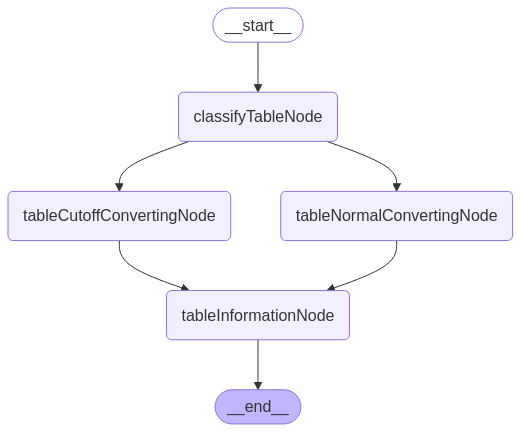

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        table_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [27]:
from langgraph.graph import StateGraph, END, START
from langchain_core.runnables import RunnableConfig

workflow = StateGraph(GraphState)

workflow.add_node('documentSummaryNode', documentSummaryNode)
workflow.add_node('cropNode', cropNode)
workflow.add_node('imageExtractorNode', imageExtractorNode)
workflow.add_node('chartExtractorNode', chartExtractorNode)
workflow.add_node('subGraph_tabelExtractorNode', table_graph)
workflow.add_node('alignNode', alignNode)

workflow.add_edge(START, 'documentSummaryNode')
workflow.add_edge('documentSummaryNode', 'cropNode')
workflow.add_edge('cropNode', 'imageExtractorNode')
workflow.add_edge('cropNode', 'chartExtractorNode')
workflow.add_edge('cropNode', 'subGraph_tabelExtractorNode')
workflow.add_edge('subGraph_tabelExtractorNode', 'alignNode')
workflow.add_edge('imageExtractorNode', 'alignNode')
workflow.add_edge('chartExtractorNode', 'alignNode')

workflow.add_edge('alignNode', END)

graph = workflow.compile()

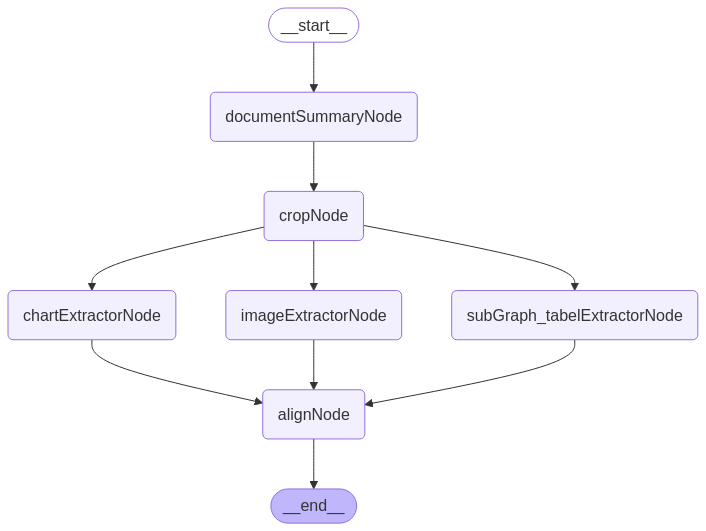

In [28]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [29]:
with open('../data/document/역도/documentParseGraph_state.json', 'r') as f:
    new_state = json.load(f)

class GraphState(TypedDict):
    filepath: Annotated[str, 'filepath']
    filepath_pdf: Annotated[str, 'pdf filepath']
    originData: Annotated[List[Dict], 'originData']
    documents: Annotated[List[Dict], 'documents']

    heading_structure: Annotated[List[str], 'heading structure. last heading is borderline']
    unused_elements: Annotated[List[Tuple[str, str]], 'unused elements']
    image_result: Annotated[List[Dict], 'result of image information extractor']
    chart_result: Annotated[List[Dict], 'result of chart information extractor']
    table_result: Annotated[List[Dict], 'result of table information extractor']
    
    normal_table: Annotated[List[Dict], 'table where class is not a cutoff']
    cutoff_table: Annotated[List[Dict], 'table where class is a cutoff']
new_state = GraphState(**new_state)

In [30]:
config = RunnableConfig(recursion_limit=100)
for output in graph.stream(new_state, config):
    for key, value in output.items():
        print(f"Output from node '{key}'")
        print("---")

Output from node 'documentSummaryNode'
---
Output from node 'cropNode'
---
Output from node 'imageExtractorNode'
---
Output from node 'chartExtractorNode'
---
Output from node 'subGraph_tabelExtractorNode'
---
Output from node 'alignNode'
---


### 결과 확인

In [31]:
with open('../data/document/역도/역도 훈련프로그램 구성 및 지도안_before_align.json', 'r') as f:
    before_align = json.load(f)

with open('../data/document/역도/역도 훈련프로그램 구성 및 지도안_dataset.json', 'r') as f:
    dataset = json.load(f)

In [32]:
dataset['documents']

[{'meta': {'filepath': '../data/document/역도/역도 훈련프로그램 구성 및 지도안_edited.json',
   'heading': {'heading1': 'Ⅴ.역도 훈련프로그램 구성 및 지도안',
    'heading2': '1. 훈련프로그램의 구성 원리',
    'heading3': None,
    'heading4': None,
    'heading5': None,
    'default': None},
   'index': 0,
   'summary': '문서에서는 역도 훈련 프로그램의 구성 및 지도안에 대해 다루고 있다. 훈련 프로그램의 구성 원리는 트레이닝의 원리에 입각하여 안전하고 효과적인 훈련 프로그램을 설계하는 것으로, 선수 개개인의 특수성, 과부하, 점진성의 일반적인 훈련 원칙에 근거하고 있다.',
   'pages': [1]},
  'content': [{'category': 'paragraph',
    'information': '역도 훈련프로그램의 구성은 트레이닝의 원리에 입각하여 안전하고 효과적인 훈\n련 프로그램을 설계하여 선수 개개인의 특수성, 과부하, 점진성의 일반적인 훈련원\n칙에 근거한다.'}]},
 {'meta': {'filepath': '../data/document/역도/역도 훈련프로그램 구성 및 지도안_edited.json',
   'heading': {'heading1': 'Ⅴ.역도 훈련프로그램 구성 및 지도안',
    'heading2': '1. 훈련프로그램의 구성 원리',
    'heading3': '가. 일반적인 훈련원칙(general training principle)',
    'heading4': '1) 특수성(specificity)',
    'heading5': None,
    'default': None},
   'index': 1,
   'summary': '문서에서는 역도 훈련 프로그램의 구성 및 지도안에 대해 다루고 있으며, 특히 훈련 프로그램의 구성 